## Content_Based Recommender System

Data 690 NLP final project
#https://grouplens.org/datasets/movielens/

CSV from Educational file

In [1]:
import pandas as pd

df_movies = pd.read_csv("https://raw.githubusercontent.com/isanjawa/Data690_NLP/main/movies.csv")

df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [2]:

df_links = pd.read_csv("https://raw.githubusercontent.com/isanjawa/Data690_NLP/main/links.csv")


df_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [3]:

df_tags = pd.read_csv("https://raw.githubusercontent.com/isanjawa/Data690_NLP/main/tags.csv")

df_tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [4]:
df_tmdb = pd.read_csv('https://raw.githubusercontent.com/isanjawa/Data690_NLP/main/tmdb_5000_movies.csv')
df_tmdb.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [5]:
# Extracting columns from df_tmdb

df_overview = df_tmdb[['id', 'overview', 'title']]
df_overview.head()

,id,overview,title
0,19995,"In the 22nd century, a paraplegic Marine is di...",Avatar
1,285,"Captain Barbossa, long believed to be dead, ha...",Pirates of the Caribbean: At World's End
2,206647,A cryptic message from Bond’s past sends him o...,Spectre
3,49026,Following the death of District Attorney Harve...,The Dark Knight Rises
4,49529,"John Carter is a war-weary, former military ca...",John Carter


## Building our Recommender system

In [6]:
import nltk
nltk.download('punkt')

def tokenize(text):
    token = nltk.word_tokenize(text)
    return token

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
df1 = df_tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x.astype(str))).reset_index()
df1.head()

,movieId,tag
0,1,pixar pixar fun
1,2,fantasy magic board game Robin Williams game
2,3,moldy old
3,5,pregnancy remake
4,7,remake


In [8]:
df1['tokens'] = df1.apply(lambda row: tokenize(row['tag']), axis=1)
df1.head()

,movieId,tag,tokens
0,1,pixar pixar fun,"[pixar, pixar, fun]"
1,2,fantasy magic board game Robin Williams game,"[fantasy, magic, board, game, Robin, Williams,..."
2,3,moldy old,"[moldy, old]"
3,5,pregnancy remake,"[pregnancy, remake]"
4,7,remake,[remake]


In [9]:
#!spacy download es_core_news_sm

In [10]:
#!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz


In [11]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [12]:
def person_name(df):
    # Processing text in the rows
    df_a = nlp(df)
    # extracting named entities
    df_b = [ent.text for ent in df_a.ents if ent.label_ == 'PERSON' ]
     
    for i in range(0, len(df_b)):
      
      df_b[i] = ''.join(tokenize(df_b[i])).lower()

    
    return ("" .join(df_b))
  
    
df1['cast'] = df1['tag'].apply(person_name)

df1.head()

,movieId,tag,tokens,cast
0,1,pixar pixar fun,"[pixar, pixar, fun]",
1,2,fantasy magic board game Robin Williams game,"[fantasy, magic, board, game, Robin, Williams,...",robinwilliams
2,3,moldy old,"[moldy, old]",
3,5,pregnancy remake,"[pregnancy, remake]",
4,7,remake,[remake],


In [13]:
newDF = pd.merge(df1, df_movies, on='movieId')
newDF.head()

,movieId,tag,tokens,cast,title,genres
0,1,pixar pixar fun,"[pixar, pixar, fun]",,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,fantasy magic board game Robin Williams game,"[fantasy, magic, board, game, Robin, Williams,...",robinwilliams,Jumanji (1995),Adventure|Children|Fantasy
2,3,moldy old,"[moldy, old]",,Grumpier Old Men (1995),Comedy|Romance
3,5,pregnancy remake,"[pregnancy, remake]",,Father of the Bride Part II (1995),Comedy
4,7,remake,[remake],,Sabrina (1995),Comedy|Romance


In [14]:
newDF['genre tokens'] = newDF.apply(lambda row: row['genres'].split('|'), axis=1)
newDF.head()

,movieId,tag,tokens,cast,title,genres,genre tokens
0,1,pixar pixar fun,"[pixar, pixar, fun]",,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,fantasy magic board game Robin Williams game,"[fantasy, magic, board, game, Robin, Williams,...",robinwilliams,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]"
2,3,moldy old,"[moldy, old]",,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]"
3,5,pregnancy remake,"[pregnancy, remake]",,Father of the Bride Part II (1995),Comedy,[Comedy]
4,7,remake,[remake],,Sabrina (1995),Comedy|Romance,"[Comedy, Romance]"


In [15]:
mergeIDs = pd.merge(df_links, newDF, on='movieId')
mergeIDs.head()

,movieId,imdbId,tmdbId,tag,tokens,cast,title,genres,genre tokens
0,1,114709,862.0,pixar pixar fun,"[pixar, pixar, fun]",,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,113497,8844.0,fantasy magic board game Robin Williams game,"[fantasy, magic, board, game, Robin, Williams,...",robinwilliams,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]"
2,3,113228,15602.0,moldy old,"[moldy, old]",,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]"
3,5,113041,11862.0,pregnancy remake,"[pregnancy, remake]",,Father of the Bride Part II (1995),Comedy,[Comedy]
4,7,114319,11860.0,remake,[remake],,Sabrina (1995),Comedy|Romance,"[Comedy, Romance]"


In [16]:
df_overview["tmdbId"] = pd.to_numeric(df_overview['id'], errors='coerce',downcast="integer")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
mergeIDs = pd.merge(mergeIDs, df_overview, on='tmdbId', how='outer')
mergeIDs.head()

,movieId,imdbId,tmdbId,tag,tokens,cast,title_x,genres,genre tokens,id,overview,title_y
0,1.0,114709.0,862.0,pixar pixar fun,"[pixar, pixar, fun]",,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",862.0,"Led by Woody, Andy's toys live happily in his ...",Toy Story
1,2.0,113497.0,8844.0,fantasy magic board game Robin Williams game,"[fantasy, magic, board, game, Robin, Williams,...",robinwilliams,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]",NaN,NaN,NaN
2,3.0,113228.0,15602.0,moldy old,"[moldy, old]",,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]",NaN,NaN,NaN
3,5.0,113041.0,11862.0,pregnancy remake,"[pregnancy, remake]",,Father of the Bride Part II (1995),Comedy,[Comedy],NaN,NaN,NaN
4,7.0,114319.0,11860.0,remake,[remake],,Sabrina (1995),Comedy|Romance,"[Comedy, Romance]",NaN,NaN,NaN


In [18]:
import re
def removeYear(title):
  return re.sub(r'\([^)]*\)', '', str(title))

mergeIDs['title_x'] = mergeIDs['title_x'].fillna(mergeIDs['title_y'])
mergeIDs['title'] = mergeIDs.apply(lambda row: removeYear(row['title_x']), axis=1)

mergeIDs['tokens'] = mergeIDs['tokens'].fillna("")
mergeIDs['genre tokens'] = mergeIDs['genre tokens'].fillna("")
mergeIDs['overview'] = mergeIDs['overview'].fillna("")
mergeIDs['cast'] = mergeIDs['cast'].fillna("")

cleanDF = mergeIDs.drop(['movieId', 'imdbId', 'tag', 'title_x', 'genres', 'id', 'title_y'], axis=1)

cleanDF.head()

,tmdbId,tokens,cast,genre tokens,overview,title
0,862.0,"[pixar, pixar, fun]",,"[Adventure, Animation, Children, Comedy, Fantasy]","Led by Woody, Andy's toys live happily in his ...",Toy Story
1,8844.0,"[fantasy, magic, board, game, Robin, Williams,...",robinwilliams,"[Adventure, Children, Fantasy]",,Jumanji
2,15602.0,"[moldy, old]",,"[Comedy, Romance]",,Grumpier Old Men
3,11862.0,"[pregnancy, remake]",,[Comedy],,Father of the Bride Part II
4,11860.0,[remake],,"[Comedy, Romance]",,Sabrina


In [19]:
pip install clean-text

     |████████████████████████████████| 71kB 3.9MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
  Created wheel for ftfy: filename=ftfy-5.8-cp36-none-any.whl size=45612 sha256=7b2dbf9805558eec3b9f4129027a70cd7fda4c8e17a83a7efd5ca7404fa9dc33
  Stored in directory: /root/.cache/pip/wheels/ba/c0/ef/f28c4da5ac84a4e06ac256ca9182fc34fa57fefffdbc68425b
  Created wheel for emoji: filename=emoji-0.6.0-cp36-none-any.whl size=49716 sha256=bb341132b8789cc5ae791a263587504436bcd2582f70ec82893b680b309136b7
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
Successfully built ftfy emoji


In [20]:
#Clean the text to remove unnecesary characters
from cleantext import clean

cleanDF['overview'] = cleanDF.apply(lambda row: clean(row['overview'],
    fix_unicode=True,               # fix various unicode errors
    to_ascii=True,                  # transliterate to closest ASCII representation
    lower=True,                     # lowercase text
    no_line_breaks=True,           # fully strip line breaks as opposed to only normalizing them
    no_urls=True,                  # replace all URLs with a special token
    no_emails=True,                # replace all email addresses with a special token
    no_phone_numbers=True,         # replace all phone numbers with a special token
    no_numbers=True,               # replace all numbers with a special token
    no_digits=True,                # replace all digits with a special token
    no_currency_symbols=True,      # replace all currency symbols with a special token
    no_punct=True,                 # fully remove punctuation
    replace_with_url="",
    replace_with_email="",
    replace_with_phone_number="",
    replace_with_number="",
    replace_with_digit="",
    replace_with_currency_symbol="",
    lang="en"                       
), axis=1)
cleanDF.head()

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


,tmdbId,tokens,cast,genre tokens,overview,title
0,862.0,"[pixar, pixar, fun]",,"[Adventure, Animation, Children, Comedy, Fantasy]",led by woody andys toys live happily in his ro...,Toy Story
1,8844.0,"[fantasy, magic, board, game, Robin, Williams,...",robinwilliams,"[Adventure, Children, Fantasy]",,Jumanji
2,15602.0,"[moldy, old]",,"[Comedy, Romance]",,Grumpier Old Men
3,11862.0,"[pregnancy, remake]",,[Comedy],,Father of the Bride Part II
4,11860.0,[remake],,"[Comedy, Romance]",,Sabrina


In [21]:
def listToString(s):  
    
    # initialize an empty string 
    str1 = " " 
    
    # return string   
    return (str1.join(s)) 


tokenCols = ['tokens', 'genre tokens']
for col in tokenCols:
  cleanDF[col] = cleanDF.apply(lambda row: listToString(row[col]),axis = 1)


cleanDF['combined tokens'] = cleanDF['tokens'] + " " + cleanDF['genre tokens'] + " " + cleanDF['overview'] + " " + cleanDF['cast']
cleanDF['combined tokens'] = cleanDF.apply(lambda row: tokenize(row['combined tokens']), axis=1)
cleanDF.head()

,tmdbId,tokens,cast,genre tokens,overview,title,combined tokens
0,862.0,pixar pixar fun,,Adventure Animation Children Comedy Fantasy,led by woody andys toys live happily in his ro...,Toy Story,"[pixar, pixar, fun, Adventure, Animation, Chil..."
1,8844.0,fantasy magic board game Robin Williams game,robinwilliams,Adventure Children Fantasy,,Jumanji,"[fantasy, magic, board, game, Robin, Williams,..."
2,15602.0,moldy old,,Comedy Romance,,Grumpier Old Men,"[moldy, old, Comedy, Romance]"
3,11862.0,pregnancy remake,,Comedy,,Father of the Bride Part II,"[pregnancy, remake, Comedy]"
4,11860.0,remake,,Comedy Romance,,Sabrina,"[remake, Comedy, Romance]"


In [22]:
# Will use this dataframe for doc2vec similarity
df_doc2vec = cleanDF.rename(columns = {'genre tokens': 'genre_tokens', 'combined tokens':'combined_tokens'})
df_doc2vec.head()

,tmdbId,tokens,cast,genre_tokens,overview,title,combined_tokens
0,862.0,pixar pixar fun,,Adventure Animation Children Comedy Fantasy,led by woody andys toys live happily in his ro...,Toy Story,"[pixar, pixar, fun, Adventure, Animation, Chil..."
1,8844.0,fantasy magic board game Robin Williams game,robinwilliams,Adventure Children Fantasy,,Jumanji,"[fantasy, magic, board, game, Robin, Williams,..."
2,15602.0,moldy old,,Comedy Romance,,Grumpier Old Men,"[moldy, old, Comedy, Romance]"
3,11862.0,pregnancy remake,,Comedy,,Father of the Bride Part II,"[pregnancy, remake, Comedy]"
4,11860.0,remake,,Comedy Romance,,Sabrina,"[remake, Comedy, Romance]"


In [23]:
#Lemmatize the tokens
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

def lemma(tokens):
    tokenList = []
    for token in tokens:
        tokenList.append(wordnet_lemmatizer.lemmatize(token))
    return tokenList

cleanDF['combined tokens'] = cleanDF.apply(lambda row: lemma(row['combined tokens']), axis=1)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [24]:
import spacy
sp = spacy.load('en_core_web_sm')
all_stopwords = sp.Defaults.stop_words

def removeStopWords(tokens):
    tokens_without_sw = [word for word in tokens if not word in all_stopwords]
    return tokens_without_sw

cleanDF['combined tokens'] = cleanDF.apply(lambda row: removeStopWords(row['combined tokens']), axis=1)
cleanDF['combined tokens'] = cleanDF.apply(lambda row: listToString(row['combined tokens']), axis=1)
cleanDF.head()

,tmdbId,tokens,cast,genre tokens,overview,title,combined tokens
0,862.0,pixar pixar fun,,Adventure Animation Children Comedy Fantasy,led by woody andys toys live happily in his ro...,Toy Story,pixar pixar fun Adventure Animation Children C...
1,8844.0,fantasy magic board game Robin Williams game,robinwilliams,Adventure Children Fantasy,,Jumanji,fantasy magic board game Robin Williams game A...
2,15602.0,moldy old,,Comedy Romance,,Grumpier Old Men,moldy old Comedy Romance
3,11862.0,pregnancy remake,,Comedy,,Father of the Bride Part II,pregnancy remake Comedy
4,11860.0,remake,,Comedy Romance,,Sabrina,remake Comedy Romance


In [25]:
cleanDF['combined tokens'] = cleanDF.apply(lambda row: row['combined tokens'].lower(), axis=1)
cleanDF.head()

,tmdbId,tokens,cast,genre tokens,overview,title,combined tokens
0,862.0,pixar pixar fun,,Adventure Animation Children Comedy Fantasy,led by woody andys toys live happily in his ro...,Toy Story,pixar pixar fun adventure animation children c...
1,8844.0,fantasy magic board game Robin Williams game,robinwilliams,Adventure Children Fantasy,,Jumanji,fantasy magic board game robin williams game a...
2,15602.0,moldy old,,Comedy Romance,,Grumpier Old Men,moldy old comedy romance
3,11862.0,pregnancy remake,,Comedy,,Father of the Bride Part II,pregnancy remake comedy
4,11860.0,remake,,Comedy Romance,,Sabrina,remake comedy romance


In [26]:
#Import TfIdfVectorizer from the scikit-learn library
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stopwords
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
cleanDF['combined tokens'] = cleanDF['combined tokens'].fillna('')

#Construct the required TF-IDF matrix by applying the fit_transform method on the overview feature
tfidf_matrix = tfidf.fit_transform(cleanDF['combined tokens'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(5621, 20829)

In [27]:
# Import linear_kernel to compute the dot product
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [28]:
#Construct a reverse mapping of indices and movie titles, and drop duplicate titles, if any
indices = pd.Series(cleanDF.index, index=cleanDF['title']).drop_duplicates()

#indices


In [29]:
# Function that takes in movie title as input and gives recommendations 
def content_recommender(title, cosine_sim=cosine_sim, cleanDF=cleanDF, indices=indices):
    # Obtain the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    # And convert it into a list of tuples as described above
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the cosine similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies. Ignore the first movie.
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return cleanDF['title'].iloc[movie_indices]

In [30]:
#Get recommendations for The Lion King
content_recommender('Seventh Son')

3653                      Snitch
2397    Riding in Cars with Boys
5110                     Hatchet
367                   Omen, The 
3200                    Forsaken
1762                 The Patriot
4451             Duel in the Sun
5564             Happy Christmas
4600                 Rabbit Hole
4202          The Purge: Anarchy
Name: title, dtype: object

In [31]:
content_recommender('Thunderball')

925                         Heaven 
2653          Never Say Never Again
1573                        Spectre
4352           Diamonds Are Forever
5254            In Her Line of Fire
4305                       Restless
4362    The Man with the Golden Gun
2982                      Octopussy
1869           K-19: The Widowmaker
2649                    Blue Streak
Name: title, dtype: object

################################

In [32]:
# Use the same function as above to create a list of 200 similar movies, that we will use to plot a dendogram
sim_scores = []
def content_recommender(title, cosine_sim=cosine_sim, cleanDF=cleanDF, indices=indices):
    # Obtain the index of the movie that matches the title
    global sim_scores
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    # And convert it into a list of tuples as described above
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the cosine similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies. Ignore the first movie.
    sim_scores = sim_scores[1:201]
    
    return sim_scores
 


content_recommender('Thunderball')    

[(925, 0.21074693413428933),
 (2653, 0.20845324925025654),
 (1573, 0.20308498815373868),
 (4352, 0.1561011164756591),
 (5254, 0.14692063511915018),
 (4305, 0.14182562610235483),
 (4362, 0.1413536204718482),
 (2982, 0.13898811248711435),
 (1869, 0.12966771881663205),
 (2649, 0.12916580644751008),
 (2529, 0.1282169722422992),
 (1536, 0.12818857779442452),
 (2336, 0.1264235340868436),
 (4181, 0.12621549975865015),
 (4971, 0.12471606152924368),
 (2512, 0.12444729019823766),
 (2601, 0.11690828405732354),
 (5138, 0.11492739641815944),
 (3773, 0.1141373977310927),
 (857, 0.11358987252302429),
 (3077, 0.11164490683473234),
 (2118, 0.1103464035734698),
 (3166, 0.11008079137196104),
 (3516, 0.1073211578935944),
 (1580, 0.10376409947062001),
 (2554, 0.103623275806776),
 (1429, 0.10297516738031572),
 (3570, 0.10203806048308514),
 (2710, 0.10142546347828141),
 (3610, 0.10082162003576665),
 (2963, 0.10011710606039348),
 (100, 0.09678780697209148),
 (1701, 0.09616739898970249),
 (4357, 0.094731559386

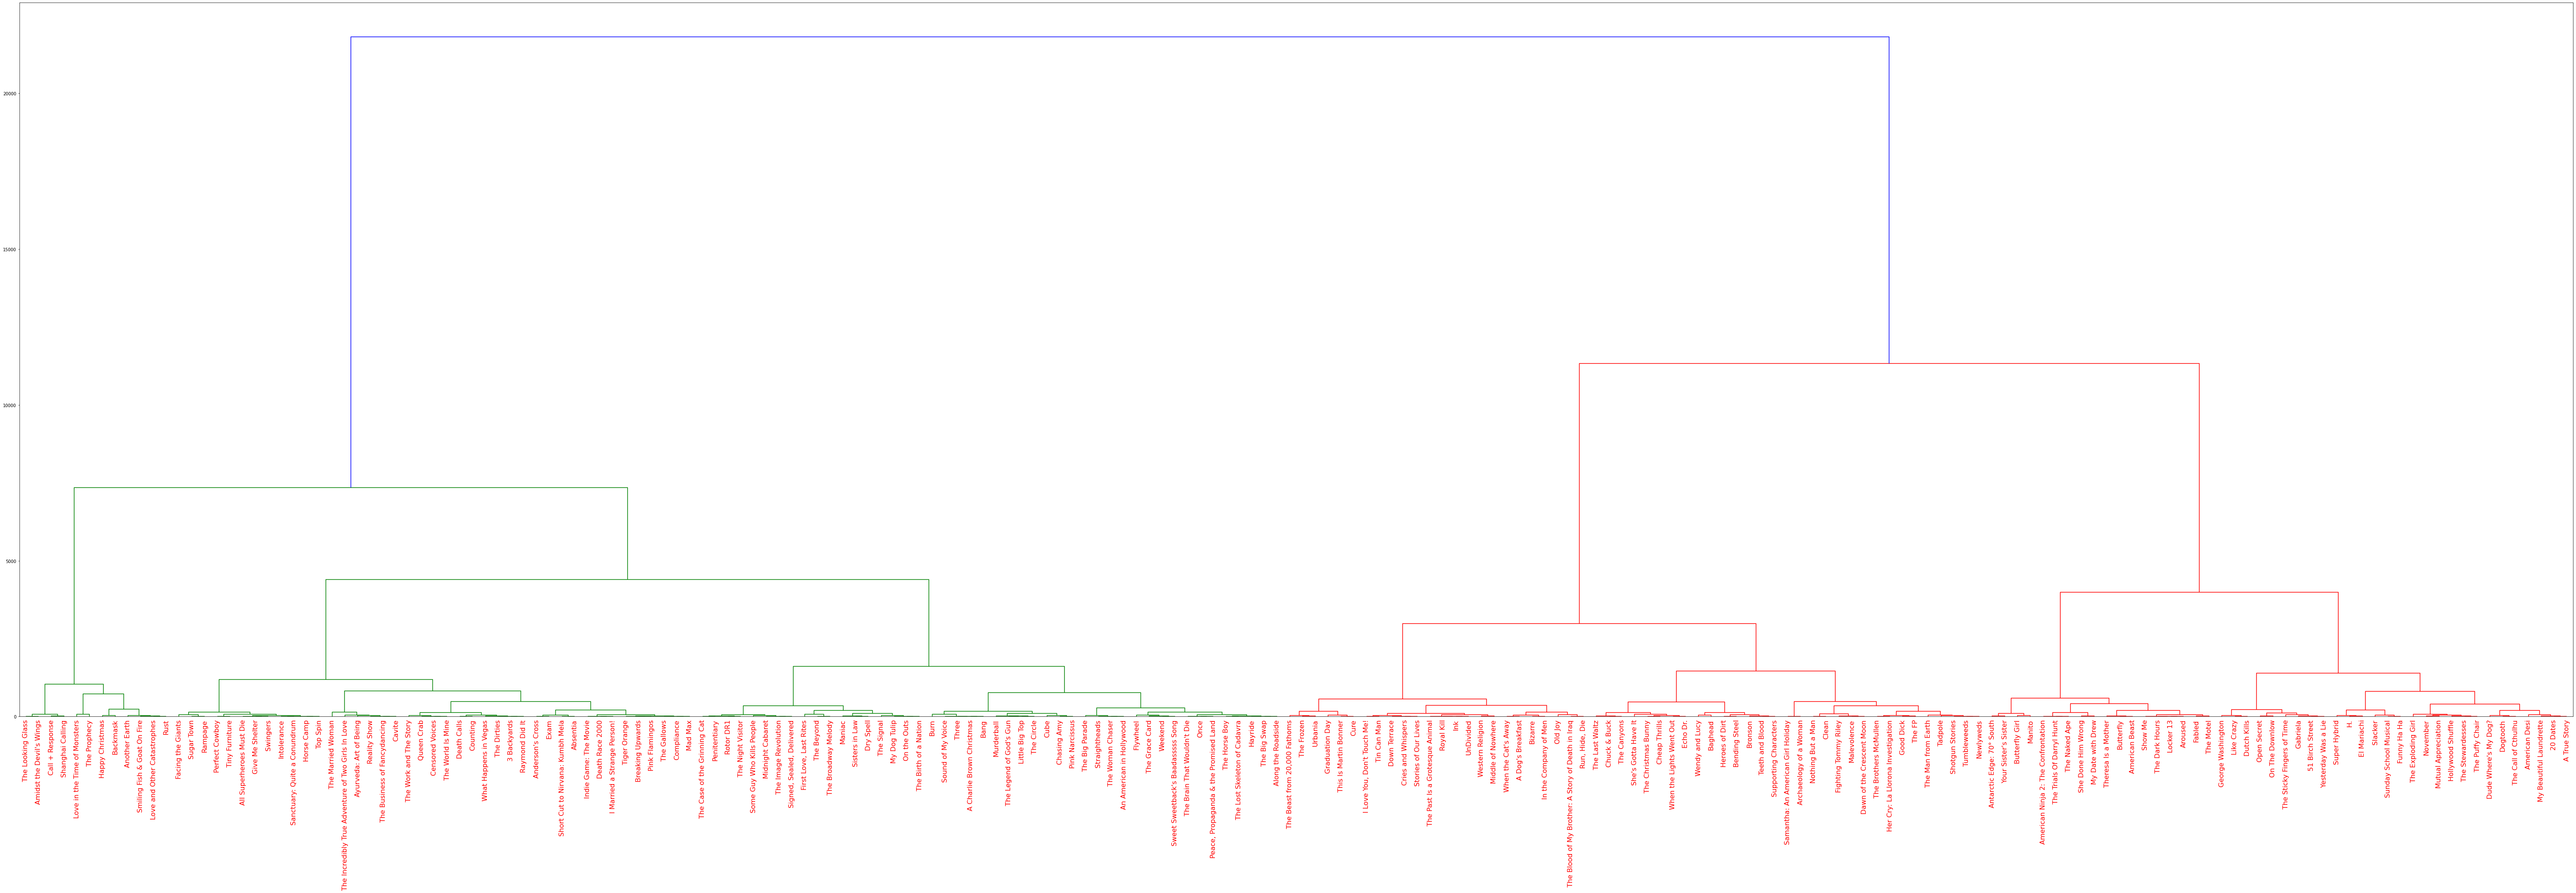

In [33]:
# Create a dendrogram of the movie_sim 
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

mergings = sch.linkage(sim_scores, method = 'ward')
#mergings[:20]

dendrogram_ = sch.dendrogram(mergings,
               labels=[x for x in cleanDF['title']],
               leaf_rotation=90,
               leaf_font_size=16,
              )

fig = plt.gcf()
_ = [lbl.set_color('r') for lbl in plt.gca().get_xmajorticklabels()]
fig.set_size_inches(108, 31)

plt.show()


#https://www.statisticshowto.com/hierarchical-clustering/


In [34]:
#cleanDF['combined tokens'].head()

df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [35]:
df_movies.iloc[8230]

movieId                                   104074
title      Percy Jackson: Sea of Monsters (2013)
genres                Adventure|Children|Fantasy
Name: 8230, dtype: object

In [36]:
# Find out all the unique genres 
temp = df_movies.genres.str.split("|").tolist() # this will return a list of lists for all the genres
import functools
import operator

unique_genres = set(functools.reduce(operator.concat, temp))


#unique_genres

In [37]:
# Count the occurences of each genres
genre_labels = set()
for s in df_movies['genres'].str.split('|').values:
  genre_labels = genre_labels.union(set(s)) 
def count_word(dataset, column, ref_col):
  keyword_count = dict()
  for s in ref_col:
    keyword_count[s]=0
  for ref_col_keyword in dataset[column].str.split('|'):
    if type(ref_col_keyword)==float and pd.isnull(ref_col_keyword):
      continue
    for s in [s for s in ref_col_keyword if s in  ref_col]:
      if pd.notnull(s):
         keyword_count[s] +=1

 # Convert the dictionary in a list, to sort the keywords by frequency.           
  keyword_occurences =[]
  for k,v in keyword_count.items():
    keyword_occurences.append([k,v])
  keyword_occurences.sort(key = lambda x:x[1], reverse = True)
  return keyword_occurences, keyword_count

# Calling this function gives access to list of genres kewords which will be sorted in decreasing frequency
keyword_occurences, dum = count_word(df_movies, 'genres', genre_labels )  
#keyword_occurences[0:]  
                          

In [38]:
#import pandas as pd 

df = pd.DataFrame(keyword_occurences, columns = ['Genres','Occurences']) 
df.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Genres,Drama,Comedy,Thriller,Action,Romance,Adventure,Crime,Sci-Fi,Horror,Fantasy,Children,Animation,Mystery,Documentary,War,Musical,Western,IMAX,Film-Noir,(no genres listed)
Occurences,4361,3756,1894,1828,1596,1263,1199,980,978,779,664,611,573,440,382,334,167,158,87,34


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

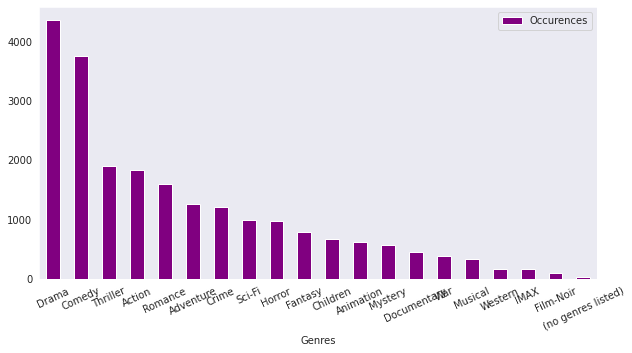

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
%matplotlib inline

# plt.figure(figsize=(10,8))
# plt.rcParams['patch.force_edgecolor'] = True
# df['Occurences'].hist(bins=50)

df.plot(x='Genres', y='Occurences', kind='bar', figsize=(10,5), color='purple')
plt.xticks(rotation=25)

In [40]:

# dummy encode the genre
#df_movies = df_movies['genres'].str.get_dummies('|')

df_movies = df_movies.join(df_movies['genres'].str.get_dummies('|'))
df_movies.head()

,movieId,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [41]:
# Create a function to get the movies recommendation

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def get_similar_movies(movie_index):
  
  # compute the cosine similarity
  cos_sim = cosine_similarity(df_movies.iloc[:,4:]) # Select all rows, from the 5th column to the end.
  print("Cosine similarity matrix: ",'\n', cos_sim[:4, :4], '\n')

  # Let's get the top 10 most similar movies:
  selected_movie_indexes = np.argsort(cos_sim[movie_index])[-10:][::-1]
 
  print('\n', "Movies similar to",df_movies['title'].iloc[movie_index], "are:" '\n')
  return df_movies['title'].iloc[selected_movie_indexes]


get_similar_movies(1)

Cosine similarity matrix:  
 [[1.         0.77459667 0.31622777 0.25819889]
 [0.77459667 1.         0.         0.        ]
 [0.31622777 0.         1.         0.81649658]
 [0.25819889 0.         0.81649658 1.        ]] 


 Movies similar to Jumanji (1995) are:



8641                                   Seventh Son (2014)
6751     Chronicles of Narnia: Prince Caspian, The (2008)
6629                           Golden Compass, The (2007)
1617                        NeverEnding Story, The (1984)
6655          Water Horse: Legend of the Deep, The (2007)
7478    Chronicles of Narnia: The Voyage of the Dawn T...
767                       Escape to Witch Mountain (1975)
7426                           Alice in Wonderland (1933)
8230                Percy Jackson: Sea of Monsters (2013)
53                     Indian in the Cupboard, The (1995)
Name: title, dtype: object

### Using K-Nearest Neighbors Algorithm

In [42]:
from sklearn.neighbors import NearestNeighbors


def neighbors():
  select_row = df_movies.iloc[:, 4:].sample(n=1)
  indx = (df_movies.iloc[:, 4:].sample(n=1)).index.values # Randomly select a movie row and extract its index value
  #print("Select a movie:" ,'\n', df_movies.loc[indx, ['title','genres']])

  
  X = df_movies.iloc[:, 4:].values
  target =select_row.values.tolist()
  

# Here we instantiate a nearest neighbor object to fit onto dataset X.
  model_knn = NearestNeighbors(n_neighbors = 10,  metric='cosine').fit(X)

# Next we find k nearest neighbor for each point in object X and print them out
  print('\n', model_knn.kneighbors(X))

#Print the recommendated movies
# the "target" point check against our k neighbors classifier.
  select_index = model_knn.kneighbors(target)
  for i in select_index[1]:
    print('\n',"Find movies similar to:" ,'\n', df_movies.loc[indx, ['title','genres']])
    print('\n','Recommendated Movies are:','\n\n', df_movies.loc[i, ['title', 'genres']] )

neighbors()  


 (array([[0.00000000e+00, 1.11022302e-16, 1.11022302e-16, ...,
        1.11022302e-16, 1.11022302e-16, 1.11022302e-16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.22044605e-16, 2.22044605e-16, ...,
        2.22044605e-16, 2.22044605e-16, 2.22044605e-16],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.22044605e-16, 2.22044605e-16, ...,
        1.83503419e-01, 1.83503419e-01, 1.83503419e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]), array([[   0, 8219, 2809, ..., 9430, 1706, 6486],
       [8230, 8641, 6751, ..., 6389, 7426,   53],
       [   2, 5178, 5182, ..., 8556, 3637, 8573],
       ...,
       [6023, 1095, 3188, ..., 3200, 1099, 3184],
       [9740, 8080, 7380, ..., 8246, 7925, 8841],
       [3171,

### Using doc2vec Gensim

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


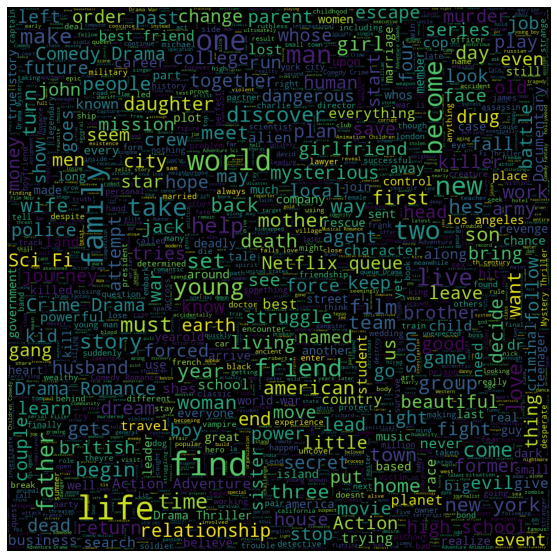

In [43]:
# Find some tags or keywords contain a lot information about the movie, and they are key features in finding similar movies.

from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
words = df_doc2vec['combined_tokens']
word = []
for i in words:
    word.extend(i)
word=pd.Series(word)
word=([i for i in word if i not in stop_words])
wc = WordCloud(background_color="black", max_words=2000, stopwords=STOPWORDS, max_font_size= 60,width=1000,height=1000)
wc.generate(" ".join(word))
plt.imshow(wc)
plt.axis('off')
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

Above is a word cloud showing the principal tags or keywords used for describing the movies.

In [44]:
# Import gensim modules.
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


In [45]:
# # Convert tokenized document into gensim formated tagged data

 
tagged_documents = []
for i, d in enumerate(df_doc2vec['combined_tokens']):
    tagged = TaggedDocument(d, [i])
    tagged_documents.append(tagged)

tagged_documents # Tagged documents are input for doc2vec model.


[TaggedDocument(words=['pixar', 'pixar', 'fun', 'Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'led', 'by', 'woody', 'andys', 'toys', 'live', 'happily', 'in', 'his', 'room', 'until', 'andys', 'birthday', 'brings', 'buzz', 'lightyear', 'onto', 'the', 'scene', 'afraid', 'of', 'losing', 'his', 'place', 'in', 'andys', 'heart', 'woody', 'plots', 'against', 'buzz', 'but', 'when', 'circumstances', 'separate', 'buzz', 'and', 'woody', 'from', 'their', 'owner', 'the', 'duo', 'eventually', 'learns', 'to', 'put', 'aside', 'their', 'differences'], tags=[0]),
 TaggedDocument(words=['fantasy', 'magic', 'board', 'game', 'Robin', 'Williams', 'game', 'Adventure', 'Children', 'Fantasy', 'robinwilliams'], tags=[1]),
 TaggedDocument(words=['moldy', 'old', 'Comedy', 'Romance'], tags=[2]),
 TaggedDocument(words=['pregnancy', 'remake', 'Comedy'], tags=[3]),
 TaggedDocument(words=['remake', 'Comedy', 'Romance'], tags=[4]),
 TaggedDocument(words=['politics', 'president', 'Comedy', 'Drama', 'Romance'

In [46]:

# Create doc2vec model.
model = Doc2Vec(tagged_documents, vector_size=5, window=2, min_count=1, workers=4, epochs = 240)

# Print model vocabulary
model.wv.vocab

{'pixar': <gensim.models.keyedvectors.Vocab at 0x7f890a8bf400>,
 'fun': <gensim.models.keyedvectors.Vocab at 0x7f890aaee278>,
 'Adventure': <gensim.models.keyedvectors.Vocab at 0x7f890aaee2b0>,
 'Animation': <gensim.models.keyedvectors.Vocab at 0x7f890aaee2e8>,
 'Children': <gensim.models.keyedvectors.Vocab at 0x7f890aaee320>,
 'Comedy': <gensim.models.keyedvectors.Vocab at 0x7f890aaee358>,
 'Fantasy': <gensim.models.keyedvectors.Vocab at 0x7f890aaee390>,
 'led': <gensim.models.keyedvectors.Vocab at 0x7f890aaee3c8>,
 'by': <gensim.models.keyedvectors.Vocab at 0x7f890aaee400>,
 'woody': <gensim.models.keyedvectors.Vocab at 0x7f890aaee438>,
 'andys': <gensim.models.keyedvectors.Vocab at 0x7f890aaee470>,
 'toys': <gensim.models.keyedvectors.Vocab at 0x7f890aaee4a8>,
 'live': <gensim.models.keyedvectors.Vocab at 0x7f890aaee4e0>,
 'happily': <gensim.models.keyedvectors.Vocab at 0x7f890aaee518>,
 'in': <gensim.models.keyedvectors.Vocab at 0x7f890aaee550>,
 'his': <gensim.models.keyedvectors.

In [50]:
def d2v_get_similar_movies(movie_index):
  list_index = []
  d2v_sim_movies = []
  
  # Choose a movie's content and vectorize it. 
  overview_doc =df_doc2vec.iloc[movie_index, -1:] 
  overview_doc_new = ' '.join(map(str, overview_doc))
  overview_doc_str = model.infer_vector(overview_doc_new) 

# Calculate cosine similarity.
  Similar_movies = model.docvecs.most_similar(positive=[overview_doc_str],topn=10)
  list_index.append([i[0] for i in Similar_movies])

  for j in list_index:
    d2v_sim_movies.append(df_doc2vec["title"].iloc[j])
    

  # Output
  output = []
  for i, v in enumerate(Similar_movies):
      index = v[0]
      output.append([i + 1, (df_doc2vec['title'])[index], v[1]])

  sim_df = pd.DataFrame(output, columns=[ "rank", "movie_title", "cosine_similarity"])
  sim_df_print = print('\n',"Cosine similarity dataframe of movies similar to",df_doc2vec["title"].iloc[movie_index], ":",'\n', sim_df, '\n')  
    
  print("List of movies most similar to", df_doc2vec["title"].iloc[movie_index], ":")
  return d2v_sim_movies, sim_df_print 


d2v_get_similar_movies(1)



 Cosine similarity dataframe of movies similar to Jumanji  : 
    rank                            movie_title  cosine_similarity
0     1  Enron: The Smartest Guys in the Room            0.989665
1     2                               Salvador           0.977573
2     3                          My Lucky Star           0.976724
3     4               Sleeping with the Enemy            0.972386
4     5                             Born Free            0.972261
5     6                    The Helix... Loaded           0.971362
6     7               Grave of the Fireflies             0.971047
7     8         Fear and Loathing in Las Vegas           0.966616
8     9                            Siege, The            0.966553
9    10                     American Splendor            0.963526 

List of movies most similar to Jumanji  :


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


([1312    Enron: The Smartest Guys in the Room 
  4658                                 Salvador
  4318                            My Lucky Star
  1073                 Sleeping with the Enemy 
  981                                Born Free 
  5253                      The Helix... Loaded
  931                  Grave of the Fireflies  
  3466           Fear and Loathing in Las Vegas
  540                               Siege, The 
  1046                       American Splendor 
  Name: title, dtype: object], None)